In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,LSTM
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K

from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout

import cv2
import shutil
import glob
import os

In [2]:
base_path='../input/braintumor/Brain/train'
filepaths=[]
labels=[]
for (dir_path, dir_names, file_names) in os.walk(base_path):
    for i in file_names:
        filepaths.append(dir_path+'/'+i)
        if 'Tr-no' in (i.split('_')):
            labels.append("No")
        else: 
            labels.append("Yes")
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  5712    labels:  5712


In [3]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(5712,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
1,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
2,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
3,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes
4,../input/braintumor/Brain/train/pituitary/Tr-p...,Yes


In [4]:
print(df['labels'].value_counts())

Yes    4128
No     1584
Name: labels, dtype: int64


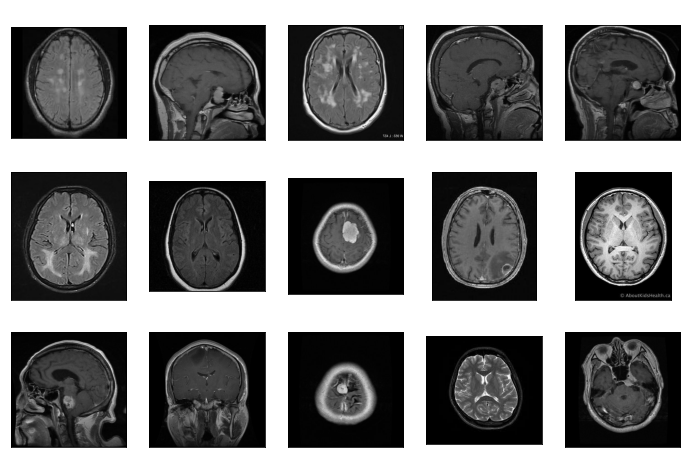

In [5]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.70, random_state=0)
train_new, valid = train_test_split(train, train_size=0.85, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (3398, 2)
test set shape: (1714, 2)
validation set shape: (600, 2)


In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [8]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (150,150), batch_size = 16, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(150,150), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (150,150), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 3398 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
Found 1714 validated image filenames belonging to 2 classes.


In [9]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [10]:
# base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape = (150,150,3),
#                                                      include_top=False)
    
# model = Sequential()
# model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(128, activation = 'relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(Reshape())


# model.add(Dense(1, activation = 'sigmoid'))
# model.summary()

**MODEL CNN + LSTM**

In [11]:
import os
input_data = Input(shape=(200,200,3), name='input')

base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape = (200,200,3),
                                                     include_top=False)
    


inner=base_model(input_data)

inner = MaxPooling2D(pool_size=(2, 2), name='pool')(inner)
inner=Dense(128,activation='relu',name='dense')(inner)
inner=BatchNormalization()(inner)
inner=Dropout(0.2)(inner)




inner = Reshape(target_shape=((inner.shape[1]*inner.shape[2],-1)), name='reshape')(inner)


inner = LSTM(100,return_sequences=True,name='lstm')(inner)

inner=Flatten()(inner)
inner = Dense(1,name='dense2')(inner)
y_pred = Activation('sigmoid', name='sigmoid')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

2022-09-09 08:42:10.729616: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 08:42:10.846452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 08:42:10.847613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 08:42:10.849888: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

219070464/219055592 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 200, 200, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
pool (MaxPooling2D)          (None, 2, 2, 1536)        0         
_________________________________________________________________
dense (Dense)                (None, 2, 2, 128)         196736    
_________________________________________________________________
batch_normalization_203 (Bat (None, 2, 2, 128)         512       
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 128)         0         
____________________________________________________________

**Model Tarining**

In [12]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
]


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = 0.0001), metrics=['accuracy',tf.keras.metrics.AUC(
    num_thresholds=200,
    curve="ROC",
    summation_method="interpolation",
    name=None,
    dtype=None,
    thresholds=None,
    multi_label=False,
    label_weights=None,
),tf.keras.metrics.Precision( thresholds=None, top_k=None, class_id=None, name=None, dtype=None ),tf.keras.metrics.Recall( thresholds=None, top_k=None, class_id=None, name=None, dtype=None ),tf.keras.metrics.TruePositives(thresholds=None, name=None, dtype=None),tf.keras.metrics.TrueNegatives(thresholds=None, name=None, dtype=None),tf.keras.metrics.FalsePositives(thresholds=None, name=None, dtype=None),tf.keras.metrics.FalseNegatives(thresholds=None, name=None, dtype=None)])


history = model.fit(train_gen, validation_data = val_gen, epochs = 40, callbacks = [callbacks], verbose = 1)


2022-09-09 08:42:22.848080: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-09-09 08:42:42.255643: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


213/213 [==============================] - 89s 295ms/step - loss: 0.3330 - accuracy: 0.9147 - auc: 0.9504 - precision: 0.9548 - recall: 0.9272 - true_positives: 2305.0000 - true_negatives: 803.0000 - false_positives: 109.0000 - false_negatives: 181.0000 - val_loss: 0.1385 - val_accuracy: 0.9517 - val_auc: 0.9929 - val_precision: 0.9395 - val_recall: 0.9952 - val_true_positives: 419.0000 - val_true_negatives: 152.0000 - val_false_positives: 27.0000 - val_false_negatives: 2.0000
Epoch 2/40
213/213 [==============================] - 45s 210ms/step - loss: 0.1183 - accuracy: 0.9635 - auc: 0.9869 - precision: 0.9774 - recall: 0.9726 - true_positives: 2418.0000 - true_negatives: 856.0000 - false_positives: 56.0000 - false_negatives: 68.0000 - val_loss: 0.0571 - val_accuracy: 0.9833 - val_auc: 0.9989 - val_precision: 0.9813 - val_recall: 0.9952 - val_true_positives: 419.0000 - val_true_negatives: 171.0000 - val_false_positives: 8.0000 - val_false_negatives: 2.0000
Epoch 3/40
213/213 [========

***Model Test***

In [13]:
model.load_weights("Tumor_classifier_model.h5")
model.evaluate(test_gen)

108/108 [==============================] - 14s 127ms/step - loss: 0.0355 - accuracy: 0.9889 - auc: 0.9985 - precision: 0.9942 - recall: 0.9902 - true_positives: 1209.0000 - true_negatives: 486.0000 - false_positives: 7.0000 - false_negatives: 12.0000


[0.03548238053917885,
 0.9889148473739624,
 0.9985049366950989,
 0.9942434430122375,
 0.9901719689369202,
 1209.0,
 486.0,
 7.0,
 12.0]

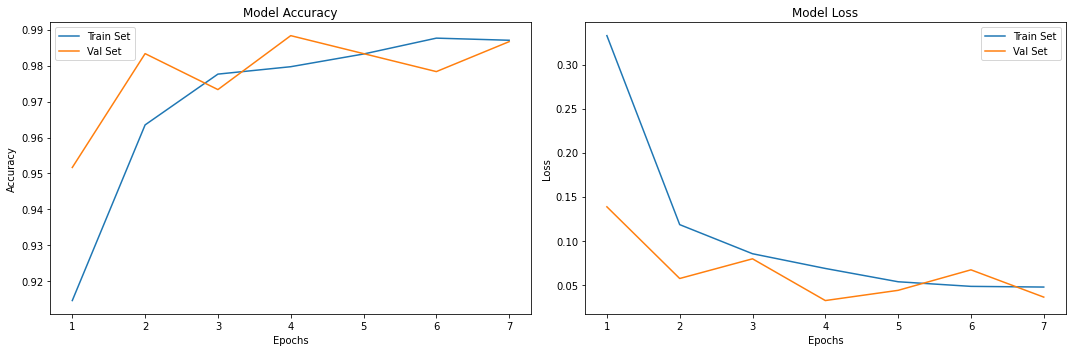

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()